In [1]:
import numpy as  np

In [2]:
#load the gsv interface
from gsv import GSVRetriever
gsv = GSVRetriever()

In [3]:
#import python modules needed for the analysis
import xarray as xr

In [60]:
#check the fdb path and schema are fine.
#modify the path inside this file to read froma different FDB
import os
os.environ["FDB5_CONFIG_FILE"] = "/scratch/project_465000454/sughosh/config.yaml"
!echo $FDB5_CONFIG_FILE

/scratch/project_465000454/sughosh/config.yaml


In [53]:
!fdb-list expver=a08t,class=rd,stream=monr,date=19500101,time=0000,levtype=sfc

Listing for request
retrieve,
	expver=a08t,
	class=rd,
	stream=monr,
	date=19500101,
	time=0000,
	levtype=sfc




{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=592416,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=593160,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=593880,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=594624,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=595344,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=596088,param=260048},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=592416,param=137},length=195700
{class=rd,expver=a08t,stream=monr,date=19500101,time=0000,domain=g}{type=fc,levtype=sfc}{step=592416

In [59]:
#request monthly 1x1deg data, modify the request below for different times
#avg_so	    263500
#avg_thetao 263122
#avg_von    263505
#avg_uoe

request = {'date':'19500101',
           'levtype': 'sfc',
           'param': 137, #['263501','263500'],
        #    'levelist': [1,10,20,30,40,45,50,55,60,65,70,75] ,
           'step': "0/to/593160",
           'time': '0000',
            'domain': 'g',
            'stream': 'monr',
            'class': 'rd',
            'type': 'fc',
            'expver': 'a08t',
            'grid' : '1/1'}


data = gsv.request_data(request)

StopIteration: 

In [8]:
data.avg_thetao

<xarray.DataArray 'avg_thetao' (time: 1, height: 12, lat: 180, lon: 360)>
dask.array<concatenate, shape=(1, 12, 180, 360), dtype=float64, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-02-01
  * height   (height) int64 1 10 20 30 40 45 50 55 60 65 70 75
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/16)
    GRIB_param:                      263501
    GRIB_shortName:                  avg_thetao
    GRIB_units:                      K
    GRIB_name:                       Time-mean sea water potential temperature
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  avg_thetao
    ...                              ...
    GRIB_NV:                         0
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avg
    GRIB_gridType:                   unstructured_grid
    GRIB_gridDefinitionDescription:  General unstructured grid
    gridtype:                        unstructured_grid

In [45]:
#function to get all the timesteps
import calendar

def get_time_steps(start_year, total_years, start_month=1, increment=1):
    """
    Generate a list of time steps in hours based on the given start year, total years, start month, and increment.

    Args:
        start_year (int): The starting year.
        total_years (int): The total number of years.
        start_month (int, optional): The starting month (1 to 12). Default is 1.
        increment (int, optional): The increment value for months. Default is 1.

    Returns:
        list: A list of time steps in hours.
    """
    if not (1 <= start_month <= 12):
        raise ValueError("start_month must be between 1 and 12")

    time_steps = [0]

    for month_count in range(0, total_years * 12, increment):
        year = (start_year + (month_count + start_month - 1) // 12)
        month = ((month_count + start_month - 1) % 12) + 1
        days_in_month = calendar.monthrange(year, month)[1]
        hours_in_month = days_in_month * 24
        time_steps.append(hours_in_month + time_steps[-1])

    return time_steps



In [46]:
request['expver'] = 'a08t'
dates = [f'{year}0101' if month == 1 else f'{year}0701' for year in range(1950, 2017) for month in [1, 7]]

counter=0
for date in dates:
    time_steps = get_time_steps(start_year=int(date[0:4]), total_years=1, start_month=int(date[4:6]))
    request['step'] = time_steps[1::] 
    request['date'] = date
    if counter == 0:
        data = gsv.request_data(request)
    else:
        data = xr.concat([data, gsv.request_data(request)], dim='time')
    
    counter += 1  # Increment the counter

StopIteration: 

In [11]:
data 

<xarray.Dataset>
Dimensions:     (time: 804, height: 12, lat: 180, lon: 360)
Coordinates:
  * time        (time) datetime64[ns] 1950-02-01 1950-03-01 ... 2017-01-01
  * height      (height) int64 1 10 20 30 40 45 50 55 60 65 70 75
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    avg_thetao  (time, height, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    avg_so      (time, height, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>

In [12]:
#compute
yearly_data = data.rename({"avg_thetao" : "ocpt", "avg_so" : "so"}).resample(time="YS").mean()
yearly_data=yearly_data.rename({"height":"lev"})
yearly_data.so

<xarray.DataArray 'so' (time: 68, lev: 12, lat: 180, lon: 360)>
dask.array<concatenate, shape=(68, 12, 180, 360), dtype=float64, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) int64 1 10 20 30 40 45 50 55 60 65 70 75
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2017-01-01
Attributes: (12/16)
    GRIB_param:                      263500
    GRIB_shortName:                  avg_so
    GRIB_units:                      g kg**-1
    GRIB_name:                       Time-mean sea water practical salinity
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  avg_so
    ...                              ...
    GRIB_NV:                         0
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avg
    GRIB_gridType:                   unstructured_grid
    GRIB_gridDefinitionDescription:  General unstructured grid
    gridtype:                        unstructured_grid

In [13]:
levels = xr.open_dataset('/scratch/project_465000454/models/IFS/inputs/inputs_de_48r1/nemo/V40/eORCA12_Z75/common/domain_cfg.nc').nav_lev.sel(z=[0,9,19,29,39,44,49,54,59,64,69,74]).values

yearly_data = yearly_data.assign_coords(lev=levels)

In [14]:
yearly_data

<xarray.Dataset>
Dimensions:  (lev: 12, lat: 180, lon: 360, time: 68)
Coordinates:
  * lev      (lev) float32 0.5058 13.99 61.11 ... 3.898e+03 4.888e+03 5.902e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2017-01-01
Data variables:
    ocpt     (time, lev, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    so       (time, lev, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>

In [17]:
import sys
sys.path.insert(0, '/app/AQUA/diagnostics')
from ocean3d import hovmoller_lev_time_plot

#this fuction did not work when using too many years.
#hovmoller_lev_time_plot(yearly_data, region= "Global Ocean", anomaly= False, standardise= False, output= False)

2023-09-12 18:04:45,289 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-09-12 18:04:50,124 - INFO - Data processed for Full values as anomaly = False
2023-09-12 18:04:50,125 - INFO - Hovmoller plotting in process


RuntimeError: can't start new thread

2023-09-08 18:41:19,604 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-09-08 18:41:20,315 - INFO - Data processed for anomaly wrt temporal mean
2023-09-08 18:41:20,318 - INFO - Hovmoller plotting in process
2023-09-08 18:43:13,353 - INFO - Figure and data used for this plot are saved here: .


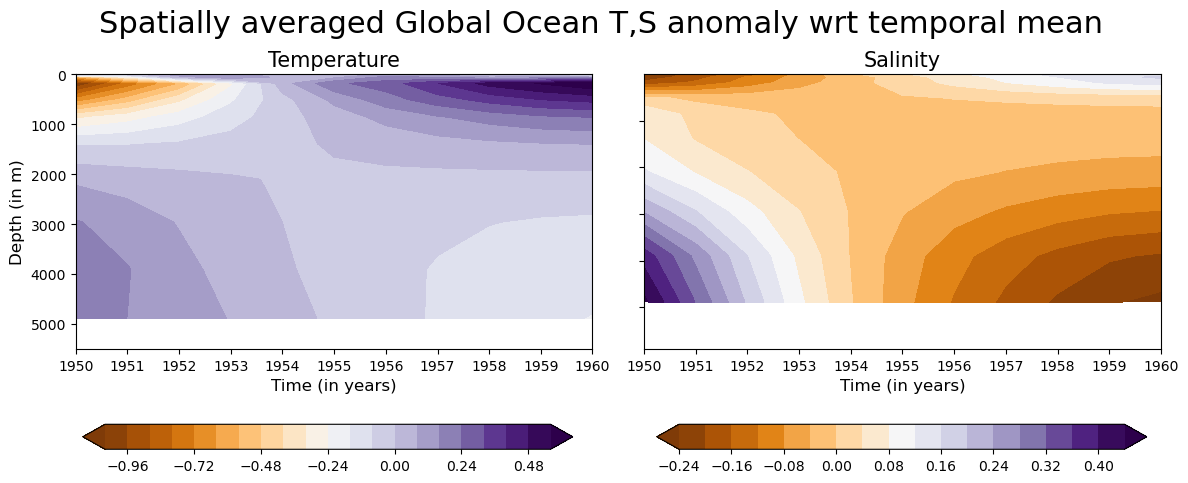

In [ ]:
hovmoller_lev_time_plot(data = yearly_data, region= "Global Ocean",
                        anomaly= True, standardise = False,                        
                        anomaly_ref = 'Tmean', output= True,
                        output_dir= '.')

2023-09-08 18:43:14,032 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-09-08 18:43:14,887 - INFO - Data processed for Std. anomaly wrt temporal mmean
2023-09-08 18:43:14,890 - INFO - Hovmoller plotting in process
2023-09-08 18:45:09,497 - INFO - Figure and data used for this plot are saved here: .


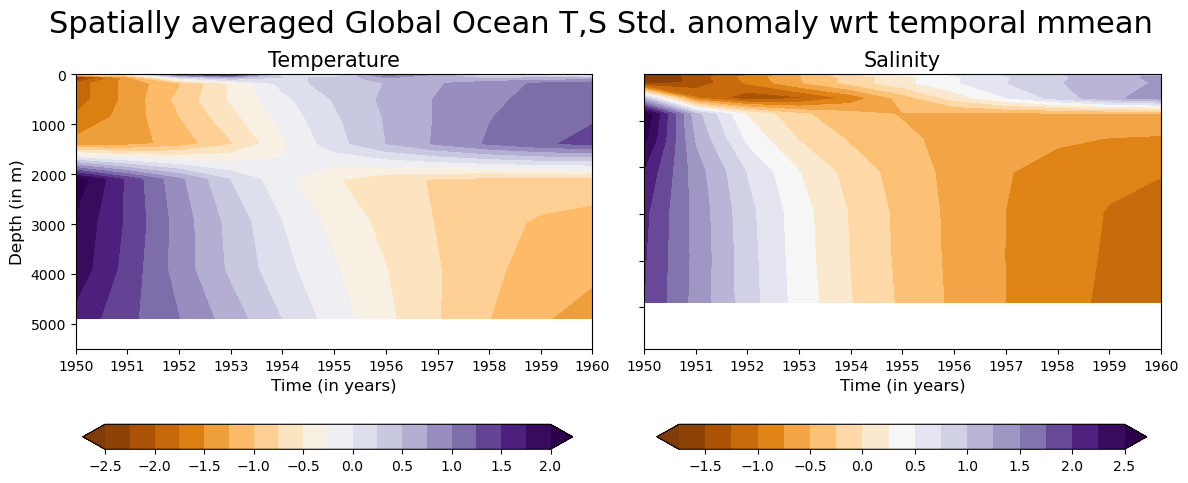

In [ ]:
hovmoller_lev_time_plot(data = yearly_data, region= "Global Ocean",
                        anomaly= True, standardise= True,                                                
                        anomaly_ref = 'tmean',
                        output= True, output_dir= '.')

In [17]:
import os
os.chdir('/scratch/project_465000454/bjimenez/jupyter_notebooks')

! pwd

/scratch/project_465000454/bjimenez/jupyter_notebooks


In [31]:
thetao_ym.sel(height=40)

<xarray.DataArray 'avg_thetao' (year: 41, ncells: 120184)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (ncells) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
    lat      (ncells) float64 -84.21 -84.21 -84.21 -84.21 ... 50.23 50.01 50.01
    height   int64 40
  * year     (year) int64 1950 1951 1952 1953 1954 ... 1986 1987 1988 1989 1990
Dimensions without coordinates: ncells
Attributes: (12/16)
    GRIB_param:                      263501
    GRIB_shortName:                  avg_thetao
    GRIB_units:                      K
    GRIB_name:                       Time-mean sea water potential temperature
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  avg_thetao
    ...                              ...
    GRIB_NV:                         0
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avg
    GRIB_gridType:                   unstructured_grid
    GRIB_gridDefinitionDescription:  General unstructured grid
    gridtype:                        unstructured_grid

In [13]:
from useful_function import compute_monthly_climatology


thetao_ym = data.avg_thetao.groupby('time.year').mean('time')

thetao = interpolate_irregular_to_regular(thetao_ym.sel(height=40),\
                                                        np.arange(90,-91,-2.5), np.arange(-180,181,2.5), method='linear')

thetao = interpolate_irregular_to_regular(thetao_ym.sel(height=40),\
                                                        np.arange(90,-91,-2.5), np.arange(-180,181,2.5), method='linear')                                                       

year


In [27]:
thetao_list = []
for height in thetao_ym.height:
    thetao_int = interpolate_irregular_to_regular(thetao_ym.sel(height=height),\
                                                        np.arange(90,-91,-2.5), np.arange(-180,181,2.5), method='linear')
    thetao_list.append(thetao_int)

year
year
year
year
year
year
year


In [82]:
thetao_levels = xr.DataArray(np.stack(thetao_list), coords=[thetao_ym.height.values] + [(thetao_list[0])[d].values for d in thetao_list[0].coords], 
                             dims=['height', 'year', 'lat', 'lon'])
thetao_levels

<xarray.DataArray (height: 7, year: 41, lat: 73, lon: 145)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan, 271.52796571, 271.52928625, ..., 271.52683199,
          271.52643334,          nan],
         [         nan, 271.53634721, 271.53885095, ..., 271.52981433,
          271.53230878,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan, 271.49597249, 271.4969247 , ..., 271.49582083,
          271.4955346 ,          nan],
         [         nan, 271.49616001, 271.49783364, ..., 271.49192405,
          271.49318479,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan, 272.55037884, 272.55153559, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
  * height   (height) int64 1 10 20 30 40 50 60
  * year     (year) int64 1950 1951 1952 1953 1954 ... 1986 1987 1988 1989 1990
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0

In [20]:
thetao_lv60 = interpolate_irregular_to_regular(thetao_ym.sel(height=60),\
                                                        np.arange(90,-91,-2.5), np.arange(-180,181,2.5), method='linear')       
thetao_lv10 = interpolate_irregular_to_regular(thetao_ym.sel(height=10),\
                                                        np.arange(90,-91,-2.5), np.arange(-180,181,2.5), method='linear')    

year
year


In [79]:
coords=[thetao_ym.height.values] + [(thetao_list[0])[d].values for d in thetao_list[0].coords]
coords

[array([ 1, 10, 20, 30, 40, 50, 60]),
 array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
        1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
        1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990]),
 array([ 90. ,  87.5,  85. ,  82.5,  80. ,  77.5,  75. ,  72.5,  70. ,
         67.5,  65. ,  62.5,  60. ,  57.5,  55. ,  52.5,  50. ,  47.5,
         45. ,  42.5,  40. ,  37.5,  35. ,  32.5,  30. ,  27.5,  25. ,
         22.5,  20. ,  17.5,  15. ,  12.5,  10. ,   7.5,   5. ,   2.5,
          0. ,  -2.5,  -5. ,  -7.5, -10. , -12.5, -15. , -17.5, -20. ,
        -22.5, -25. , -27.5, -30. , -32.5, -35. , -37.5, -40. , -42.5,
        -45. , -47.5, -50. , -52.5, -55. , -57.5, -60. , -62.5, -65. ,
        -67.5, -70. , -72.5, -75. , -77.5, -80. , -82.5, -85. , -87.5,
        -90. ]),
 array([-180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5,
        -160. , -157.5, -

In [23]:
gm_thetao = global_mean(yearly_data.ocpt)

In [19]:
import matplotlib.pyplot as plt

#import importlib
#import useful_function
#importlib.reload(useful_function)
from useful_function import global_mean
#global_mean(thetao).plot()
gm_thetao = global_mean(yearly_data.ocpt)
gm_thetao.plot()

# Customize the labels
plt.ylabel('NEMOv4 model level')
plt.xlabel('Time')
plt.title('normalized THETAO evolution control-1950 Tco79')

plt.gca().invert_yaxis()
plt.show()


RuntimeError: can't start new thread

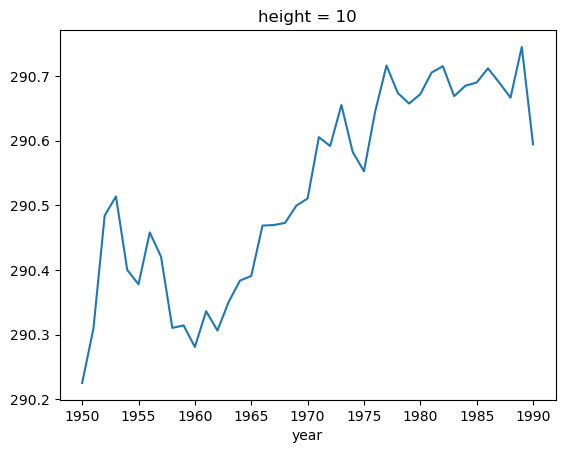

In [98]:
gm_thetao.sel(height=10).plot()

(<Figure size 1000x600 with 2 Axes>,
 <GeoAxes: title={'center': 'THETAO lev-lv40 trend (K/year) 1950-control (20-30 YR)'}, xlabel='Longitude', ylabel='Latitude'>)

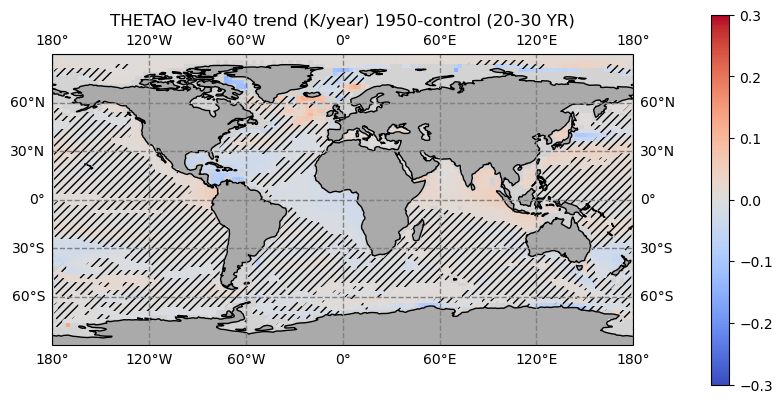

In [103]:
from useful_function import linear_trend, plot_dataarray

import numpy as np
import matplotlib.pyplot as pl
import cartopy.crs as ccrs

from scipy.stats import linregress


def calc_trend_pval(y):
    """Calculate the trend and p-value for a 1D input array."""
    # calculate linear trend
    trend, _, _, p_value, _ = linregress(np.arange(y.size), y)
    return trend, p_value

# Assuming your data array is named 'da'
# First create a new data array with the same dimensions and coordinates as 'da'
thetao_trend, p_values = xr.apply_ufunc(calc_trend_pval, thetao_levels.sel(height=40)[21:31], input_core_dims=[['year']],
                                  vectorize=True, dask='parallelized', output_core_dims=[[], []])


plot_dataarray(thetao_trend.squeeze(), significance=True, p_values=p_values, title='THETAO lev-lv40 trend (K/year) 1950-control (20-30 YR)',
                   figsize=(10, 6), vmin=-0.3, vmax=0.3, region=None,
                   cbar_kwargs={'shrink': 0.8, 'pad' : 0.1})


In [ ]:
from useful_fuctions import plot_timeseries_month_and_year

plot


In [29]:
#lets do now avg_tos

avg_1950_1959_March = interpolate_irregular_to_regular(data.avg_tos.sel(time=slice('1950-01-01','1959-12-31')).mean('time'),\
                                                        np.arange(90,-91,-1), np.arange(-180,181,1), method='linear')
avg_1960_1969_March = interpolate_irregular_to_regular(data.avg_tos.sel(time=slice('1960-01-01','1969-12-31')).mean('time'), \
                                                       np.arange(90,-91,-1), np.arange(-180,181,1), method='linear')

diff = avg_1960_1969_March - avg_1950_1959_March 

